# Boolean Network Analysis Workflow Example
This notebook demonstrate the workflow to simulate, extend and analyze a Boolean network through Probabilistic Boolean Network (PBN) approach.

In [1]:
import sys
sys.path.append('./src')
import BNMPy
import Optimizer

## Load a Boolean Network

Below is a synthetic model that describes the EGFR-RAS-MAPK pathway.

In [2]:
network_string = """
DNA_DAMAGE = DNA_DAMAGE
EGFR   = EGFR
KRAS   = EGFR
BRAF   = KRAS
MAP2K1 = BRAF
MAPK1  = MAP2K1
PIK3CA = EGFR
PTEN   = !PIK3CA              
AKT1   = PIK3CA & !PTEN
MDM2   = AKT1               
TP53   = DNA_DAMAGE & !MDM2
BAX    = TP53             
CASP3  = BAX & !AKT1 
CCND1  = MAPK1 | AKT1         
CDK2   = CCND1 & !TP53        
"""
network = BNMPy.load_network_from_string(network_string)

No initial state provided, using a random initial state
Network loaded successfully. There are 15 genes in the network.


In [3]:
data_example_file = 'files/experiments_example.csv'
measured_nodes, perturbed_nodes = Optimizer.extract_experiment_nodes(data_example_file)

   Extracted 2 measured nodes: {'AKT1', 'TP53'}
   Extracted 3 perturbed nodes: {'PIK3CA', 'EGFR', 'DNA_DAMAGE'}


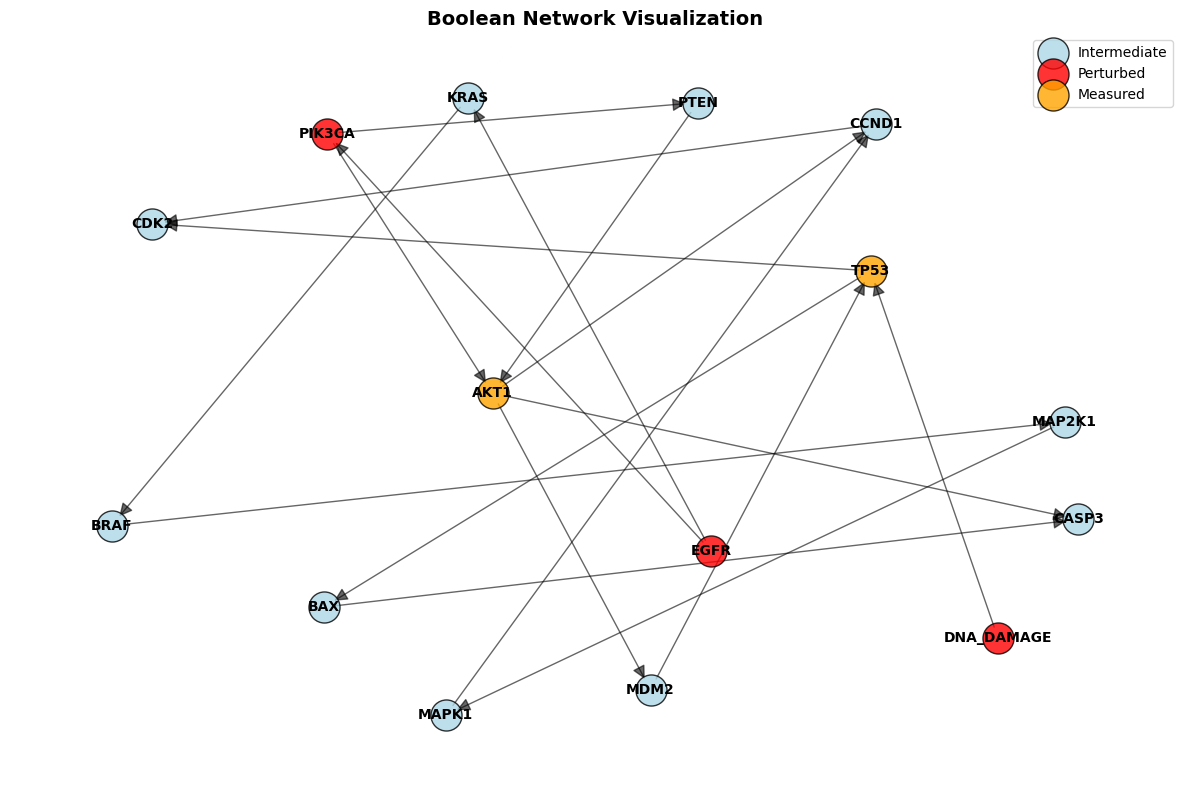

In [5]:
BNMPy.vis_network(network, measured_nodes=measured_nodes, perturbed_nodes=perturbed_nodes)

In [6]:
# Alternatively, an interactive visualization
BNMPy.vis_network(network, output_html="files/ExampleBN.html", interactive=True, measured_nodes=measured_nodes, perturbed_nodes=perturbed_nodes)

Network visualization saved to files/ExampleBN.html


## Compress the network

Before simulation, we can simplify the network by:
1. Removing non-observable nodes: 
2. Remobing non-controllable nodes
3. Collapsing linear paths

This is because these nodes and edges do not affect the dynamics of the network for the given experiments, and we could simplify the network for better efficiency.

In [7]:
compressed_network, compression_info = Optimizer.compress_model(
    network,
    measured_nodes=measured_nodes,
    perturbed_nodes=perturbed_nodes
)

Model Compression Summary:
  Measured nodes: AKT1, TP53
  Perturbed nodes: DNA_DAMAGE, EGFR, PIK3CA

Removed 8 non-observable nodes
  Non-observable: BAX, BRAF, CASP3, CCND1, CDK2, KRAS, MAP2K1, MAPK1
Removed 0 non-controllable nodes
Collapsed 0 linear paths

Total nodes removed/collapsed: 8
Final network size: 7 nodes


In [13]:
BNMPy.vis_compression_comparison(
    network,
    compressed_network, 
    compression_info,
    output_html="files/compression_example.html",
    interactive=True
)

Network visualization saved to files/compression_example.html


In [8]:
compressed_network_string = '\n'.join(compressed_network.equations)

## Standardize the network

Before extending the network using knowledge graph, we need to standardize the gene names to find a match in the knowledge graph.


## Extend the network

In [15]:
genes = network.nodeDict.keys()
KG_string, relations = BNMPy.load_signor_network(genes, joiner='inhibitor_wins')
print(KG_string)

AttributeError: module 'BNMPy' has no attribute 'build_bn_from_kg'

In [9]:
def BN2PBN(bn_string, prob=0.5):
    """
    Expand the boolean network to a PBN by adding a self-loop as alternative function
    prob: probability of the equations from the original BN

    Returns:
        pbn_string: string of the PBN
        nodes_to_optimize: list of nodes excludes input nodes
    """
    # Parse equations from BN
    bn_equations = {}
    for line in bn_string.strip().split('\n'):
        if '=' in line:
            target, rule = line.split('=', 1)
            bn_equations[target.strip()] = rule.strip()
    
    # Expand rules
    pbn_equations = []
    nodes_to_optimize = []

    for target in bn_equations.keys():
        if bn_equations[target] == target:
            # If its already a self-loop (e.g., a input node)
            pbn_equations.append(f"{target} = {bn_equations[target]}, 1")
        else:
            # Add the original rule with a prob
            pbn_equations.append(f"{target} = {bn_equations[target]}, {prob}")
            # Add the alternative rule
            pbn_equations.append(f"{target} = {target}, {round(1-prob,2)}")
            nodes_to_optimize.append(target)
    
    # remove equations with prob = 0
    pbn_equations = [eq for eq in pbn_equations if eq.split(',')[1] != ' 0']
    pbn_string = '\n'.join(pbn_equations)
    return pbn_string, nodes_to_optimize

pbn_string, nodes_to_optimize = BN2PBN(compressed_network_string, prob=0.99)
pbn = BNMPy.load_pbn_from_string(pbn_string)

print("PBN string:")
print(pbn_string)

No initial state provided, using a random initial state
PBN loaded successfully. There are 7 genes in the network.
PBN string:
DNA_DAMAGE = DNA_DAMAGE, 1
EGFR = EGFR, 1
PIK3CA = EGFR, 0.99
PIK3CA = PIK3CA, 0.01
PTEN = !PIK3CA, 0.99
PTEN = PTEN, 0.01
AKT1 = PIK3CA & !PTEN, 0.99
AKT1 = AKT1, 0.01
MDM2 = AKT1, 0.99
MDM2 = MDM2, 0.01
TP53 = DNA_DAMAGE & !MDM2, 0.99
TP53 = TP53, 0.01


In [10]:
nodes_to_optimize

['PIK3CA', 'PTEN', 'AKT1', 'MDM2', 'TP53']

## Optimize the network

### Test for convergence

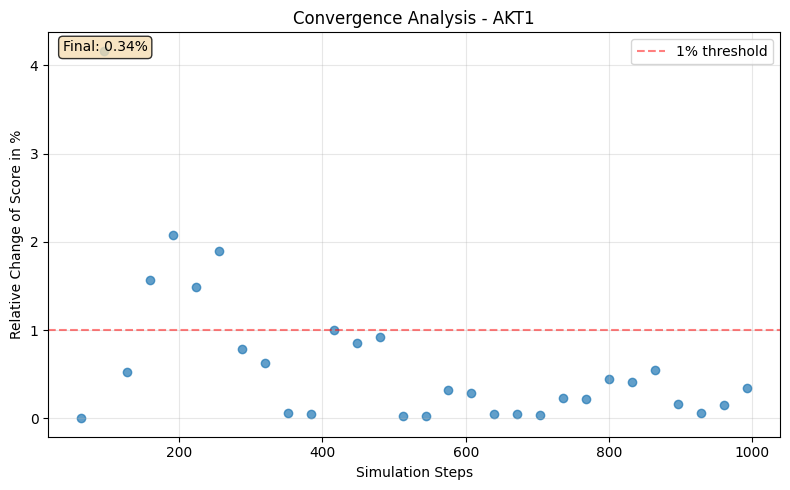

In [9]:
calc = BNMPy.SteadyStateCalculator(pbn)
calc.set_experimental_conditions(stimuli=['EGFR'],inhibitors=['PIK3CA'])
steady_state,convergence_info = calc.compute_steady_state(
    method='monte_carlo',
    n_runs=3,
    n_steps=1000,
    p_noise=0.05,
    analyze_convergence=True,
    output_node='AKT1')

### Run optimization

In [11]:
# Configure optimizer
config = {
    'pso_params': {
        'n_particles': 50,
        'iters': 100,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': -1,
        'ftol_iter': 5
    },
    'steady_state': {
        'method': 'monte_carlo',
            'monte_carlo_params': {
                'n_runs': 3,
                'n_steps': 1000,
                'p_noise': 0.05
            }
    },
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.1, # threshold for accepting fit,
    'display_rules_every': 0  # Display optimized rules every n iterations (0 = disabled)
}

In [12]:
optimizer = Optimizer.ParameterOptimizer(
    pbn,
    data_example_file, 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=True)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-07-20 17:06:05,277 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 1/2
Running PSO optimization...


PSO Setup:
  - Particles: 50
  - Max iterations: 100
  - Problem dimensions: 10
  - Total function evaluations: 5000




pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0832
2025-07-20 17:18:51,961 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.08318871969965592, best pos: [0.4098983  0.12793166 0.63319219 0.81867833 0.53683682 0.6500778
 0.65172134 0.56902319 0.45245598 0.27029852]


Success threshold achieved: 0.083189 < 0.1


In [13]:
# Configure optimizer
config = {
    'de_params': {
        'strategy': 'best1bin',
        'maxiter': 100,
        'popsize': 15,
        'tol': 0.001, 
        'atol': 0,
        'mutation': (0.5, 1),
        'recombination': 0.7,
        'seed': None,
        'disp': False,
        'init': 'sobol',
        'updating': 'deferred',
        'workers': -1,
        'early_stopping': False
    },
    'steady_state': {
        'method': 'monte_carlo',
            'monte_carlo_params': {
                'n_runs': 3,
                'n_steps': 1000,
                'p_noise': 0.05
            }
    },
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.1, # threshold for accepting fit,
    'display_rules_every': 0  # Display optimized rules every n iterations (0 = disabled)
}

optimizer = Optimizer.ParameterOptimizer(
    pbn,
    data_example_file, 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=False)

# Run optimization
result = optimizer.optimize(method='differential_evolution')


Running optimization using method: differential_evolution
Maximum attempts: 2

--- Attempt 1/2 ---
[██████████████████████████████] 100.0% | Iter: 100/100 | Best MSE: 0.088577 | Conv: 0.0181
Total time: 469.41 seconds

Successful optimization found in attempt 1
  - MSE: 0.074582

--- Optimization finished. Best MSE found: 0.074582 ---

--- Optimized PBN Rules ---
DNA_DAMAGE = DNA_DAMAGE, 1.0000
EGFR = EGFR, 1.0000
PIK3CA = EGFR, 0.8502
PIK3CA = PIK3CA, 0.1498
PTEN = !PIK3CA, 0.1132
PTEN = PTEN, 0.8868
AKT1 = PIK3CA & !PTEN, 0.5926
AKT1 = AKT1, 0.4074
MDM2 = AKT1, 0.3237
MDM2 = MDM2, 0.6763
TP53 = DNA_DAMAGE & !MDM2, 0.9588
TP53 = TP53, 0.0412
---------------------------



## Evaluate the optimized network

In [11]:
pbn_optimized = optimizer.get_optimized_pbn(result)
BNMPy.vis_network(pbn_optimized,"files/PBN_optimized.html",interactive=True,measured_nodes=measured_nodes,perturbed_nodes=perturbed_nodes)

Network visualization saved to files/PBN_optimized.html


Simulating optimized model on all experimental conditions...
  Experiment 1: 2 nodes simulated
  Experiment 2: 2 nodes simulated
  Experiment 3: 2 nodes simulated
  Experiment 4: 2 nodes simulated
  Experiment 5: 2 nodes simulated
Simulation completed: 10 data points
Plot saved to files/PBN_evaluation_results/prediction_vs_experimental.png
Residual plot saved to files/PBN_evaluation_results/residual_analysis.png
Evaluation report saved to files/PBN_evaluation_results/evaluation_report.txt
Results exported to files/PBN_evaluation_results/detailed_results.csv


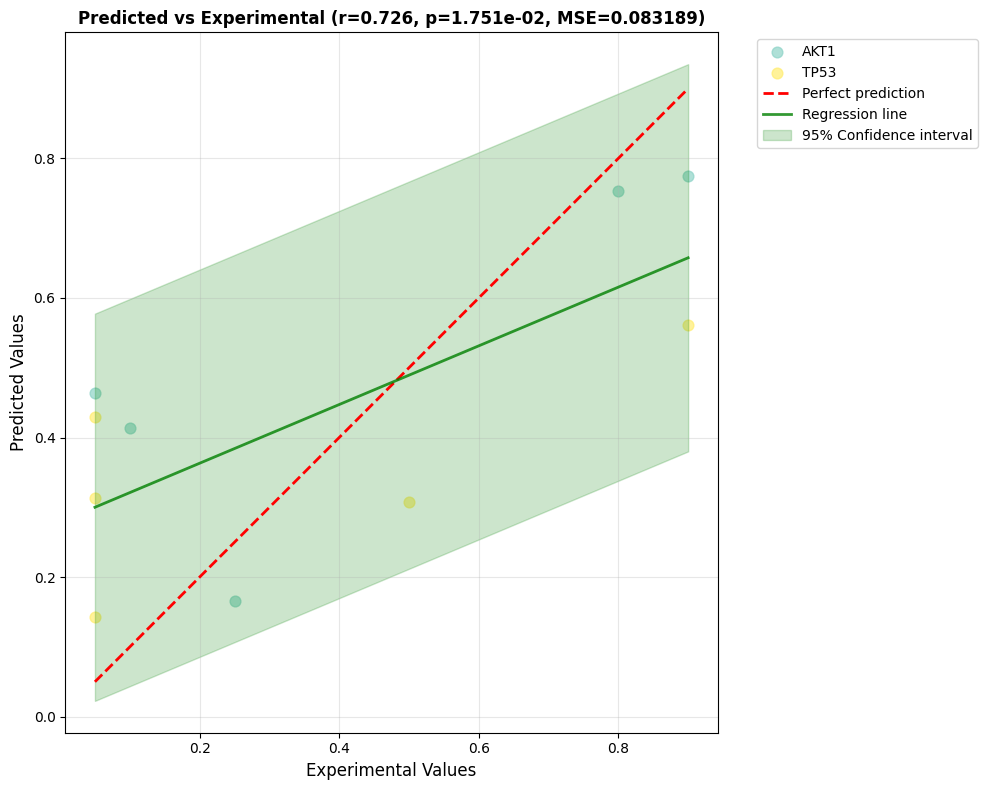

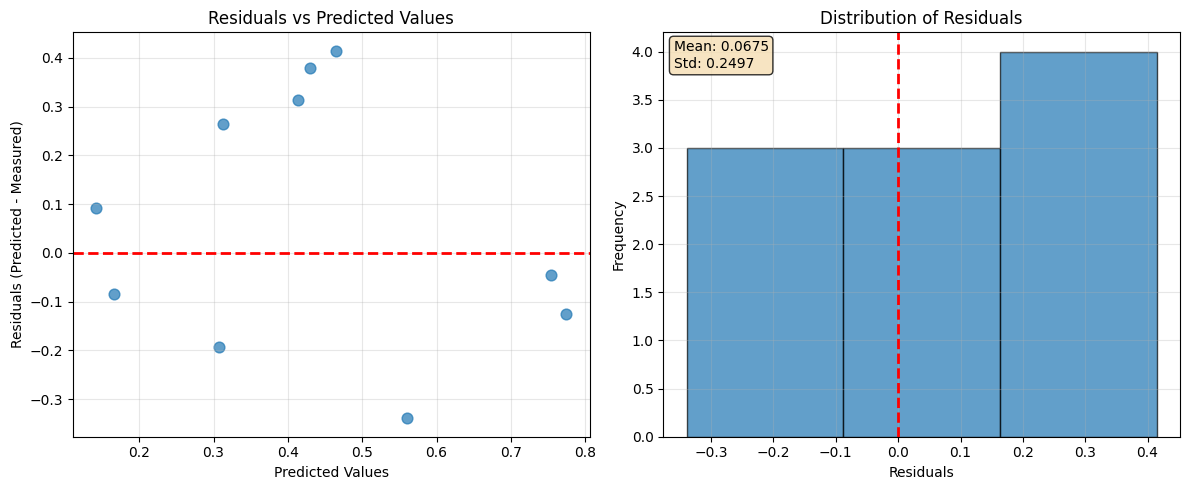

In [13]:
evaluator = Optimizer.evaluate_optimization_result(
    result, 
    optimizer, 
    output_dir="files/PBN_evaluation_results",
    generate_plots=True,
    generate_report=True
)